# Understanding Convolutional Neural Networks in PyTorch


## Introduction 

In this notebook, we will cover the foundations of Convolutional Neural Networks (CNNs) for image recognition tasks.

## Learning Objectives 

- Be aware of different types of Computer Vision tasks
- [[deep_cnn/dataset_generator]](../deep_cnn/dataset_generator.py) Load an image dataset in PyTorch
- Be able to explain what a convolutional layer does and how it's different from a fully-connected layer
- Identify different components of a CNN
- [[deep_cnn/model_builder]](../deep_cnn/model_builder.py) Load a pre-trained model in PyTorch
- [[deep_cnn/train_model]](../deep_cnn/train_model.py) Be able to use PyTorch to train a model on a dataset
- [[deep_cnn]](../deep_cnn) Iterate on design choices for model training

### Computer Vision tasks

Computer Vision aims to train computers to interpret and understand visual input. This can include image classification, object detection, pixel labeling, scene understanding and more.

| ![alt text](../images//image_tasks.jpeg "Computer Vision tasks") |
|:--:|
| <b>Source: Fei-Fei Li, Andrej Karpathy & Justin Johnson (2016) cs231n, Lecture 8 — Slide 8, Spatial Localization and Detection (01/02/2016). [Available](http://cs231n.stanford.edu/slides/2016/winter1516_lecture8.pdf).</b>|

The type of data used in Computer Vision is what is called unstructured. In contrast, structured data is typically numerical/categorical/binary and can be stored in a table. Unstructured data types include images, text, video and networks. In addition to being unstructured, image data is typically of high resolution. Think of you phone camera. An iPhone XR has a resolution of 1792 x 828 for each of the 3 Red Green and Blue channels...that's already over 4 million numbers stored for a single image. (Note that we represent each pixel in a colour image using three real-numbers for the Red, Green and Blue values -- called "channels" -- and hence the 1792x828x3 shape.)

Let's begin by loading a benchmark dataset. PyTorch has many [benchmark datasets](https://pytorch.org/vision/stable/datasets.html) but we will begin with [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html).

### Data

In [1]:
import os 
root_dir = os.path.abspath('..')

In [3]:
import torch 
import torchvision

cifar = torchvision.datasets.CIFAR10(download=True, root=root_dir + '/outputs/benchmark')

Files already downloaded and verified


In [ ]:
type(cifar) 

When we download images from pytorch, they are already loaded into a dataset. All datasets are subclasses of torch.utils.data.Dataset i.e, they have _ _getitem_ _ and _ _len_ _ methods implemented. Hence, they can all be passed to a torch.utils.data.DataLoader which can load multiple samples in parallel using torch.multiprocessing workers. Here is the full structure of the [CIFAR10 class](https://pytorch.org/vision/0.12/_modules/torchvision/datasets/cifar.html).

In [ ]:
len(cifar) # number of samples in the image dataset

In [ ]:
cifar[0] # first item of the image dataset

Note the first element of cifar is a tuple: the first entry is the image as type PIL, and the second is the outcome class 6. Let's see what class 6 refers to.

In [ ]:
cifar._load_meta
print (cifar.class_to_idx)
class_map = {value:key for key, value in cifar.class_to_idx.items()} # invert class_to_idx

Class 6 corresponds to a frog. Let's visualise this image using the PIL package:

In [ ]:
display(cifar[0][0])

Let's see what this frog looks like as an array. We convert to an array using numpy.

In [ ]:
import numpy as np
x = np.array(cifar[0][0])
x.shape

As a dataset, cifar supports iteration by calling _ _getitem_ _ as per the [PEP34](https://peps.python.org/pep-0234/) documentation:
1. An object can be iterated over with "for" if it implements
   __iter__() or __getitem__().

2. An object can function as an iterator if it implements next().

Why is this useful? In the context of deep learning with images, data can take up a lot of memory. Iterators load images in batches to preserve memory without ever needing to load the full dataset. Consider how much memory is costs to store a (224x224x3) image compared to a string with up to 100 characters. 

In [ ]:
for i, (image, target) in enumerate(cifar):
    display(image)
    print (class_map[target])
    if i == 3:
        break

### Custom Datasets using ImageFolder

Let's see how to load a dataset that isn't a benchmark from PyTorch. We'll try implementing our own custom class in the next section but since the Places365 has a specified file structure, we can make use of PyTorch class [datasets.ImageFolder()](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html) to create our own Dataset. Let's try it out with the Places265 images in the test dataset:

In [7]:
from pathlib import Path
import torchvision.datasets as datasets

root_dir = Path().resolve().parent
data_dir = Path("tests/places_test_input/")
split = "train"
dir = (root_dir / data_dir / split )

data_iterator = datasets.ImageFolder(dir)

In [8]:
data_iterator.__len__()

5

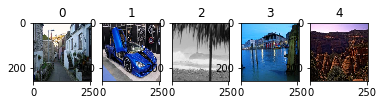

In [9]:
import matplotlib.pyplot as plt 

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
axs = [ax1,ax2,ax3,ax4,ax5]

for i, (image, target) in enumerate(data_iterator):
    axs[i].imshow(image)
    axs[i].set_title(target)

ImageFolder creates the data-target mapping internally which does not match the true target labels. We will add a mapping function to get the Places365 outcomes:

In [10]:
folders = Path('tests/places_test_input/train') 
dirs = sorted(os.listdir((root_dir / folders)) ) # read all folder names in alphanumeric order

categories = {}
for i, x in enumerate(dirs):
    categories[i] = dirs[i]                        # map each item in list to name of directory

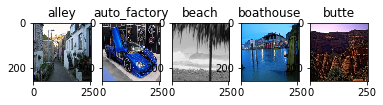

In [11]:
import matplotlib.pyplot as plt 

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
axs = [ax1,ax2,ax3,ax4,ax5]

for i, (image, target) in enumerate(data_iterator):
    axs[i].imshow(image)
    axs[i].set_title(categories[target])

# Try it Yourself

We'll create our own dataset iterator which can read in the Places365 dataset. Our custom dataset will inherit torch.utils.data.Dataset and override _ _len_ _ and _ _getitem_ _. This is useful for image datasets which do not conform to a particular file structure readable to PyTorch dataset classes.

In order to do this you will need to code the following:

- Write a function to get all samples in the test/train folder (data_dir) by location (path) and class (create a mapping which is consistent within classes).
- Read in the image from the path name

Ignore the transform option for now which is currently set to None. We will come back to that later.

In [42]:
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    """Place365 dataset."""

    def __init__(self, root_dir, data_dir, transform=None):
        """
        Args:
            root_dir (string): Path to recode-perceptions.
            data_dir (string): Directory with the images.
            transform (callable, optional): Optional transform to be applied
                on an image.
        """
        
        self.root_dir = root_dir
        self.data_dir = data_dir
        self.transform = transform

        # write a function to get a list of all images
        # and corresponding class labels 
        # call the output samples

        self.samples = samples(root_dir, data_dir)

    def __len__(self):
        """returns total number of images in dataset"""

        return 

    def __getitem__(self, idx):
        """returns next image in dataset"""

        path, label = self.samples[idx]
        # read image from path

        if self.transform:
            image = self.transform(image)

        return image, label

# write a function to get a list of all images
# and corresponding class labels 
# call the output samples
def samples(root_dir, data_dir):
    paths = []
    return paths

Below is an example of creating a Custom Image Dataset generator for the test images of Places365. For your own image dataset, this is likely to be different, and depending on whether you want to include the class labels, include transforms, or have a different data directory, this will change each time.

In [60]:
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    """Place365 dataset."""

    def __init__(self, root_dir, data_dir, transform=None):
        """
        Args:
            root_dir (string): Path to recode-perceptions.
            data_dir (string): Directory with the images.
            transform (callable, optional): Optional transform to be applied
                on an image.
        """
        
        self.root_dir = root_dir
        self.data_dir = data_dir
        self.transform = transform

        # get all images

        self.samples = samples(root_dir, data_dir)

    def __len__(self):
        """returns total number of images in dataset"""

        return 

    def __getitem__(self, idx):
        """returns next image in dataset"""

        # get next item
        path, label = self.samples[idx]
        
        # read image from path
        image = read_image(str(path))

        if self.transform:
            image = self.transform(image)

        return image, label

def samples(root_dir, data_dir):
    # get classes
    classes = sorted(entry.name for entry in os.scandir((root_dir / data_dir)) if entry.is_dir())
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

    # get images
    all = list((root_dir / data_dir).rglob("*.jpg"))

    # map images to classes
    labels = [(lambda x: class_to_idx[str(x).split('/')[-2]])(x) for x in all]
    return list(zip(all, labels))

In [53]:
data_dir = Path('tests/places_test_input/train')
dataset_iterator = CustomImageDataset(root_dir, data_dir)

In [54]:
dataset_iterator.__len__()

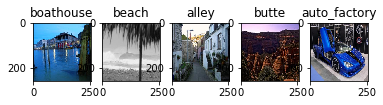

In [59]:
import matplotlib.pyplot as plt 
from torchvision import transforms

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
axs = [ax1,ax2,ax3,ax4,ax5]

for i, (image, target) in enumerate(dataset_iterator):
    im = transforms.ToPILImage()(image).convert("RGB")
    axs[i].imshow(im)
    axs[i].set_title(categories[target])


### Background

#### Artificial Neural Networks

A Multilayer Perceptron (MLP) is a class of Artificial Neural Network (ANN). The MLP consists of an input layer of neurons, one or more hidden layers and an output layer. Operations between layers are linear transformations, controlled by weights, $w$, followed by a non-linear transformation, called the activation function, as depicted in the figure below. This results in dense connections (fully connected) between layers, where each and every unit in the previous layer is connected to each and every unit in the current layer. The aforementioned weights are the internal parameters of the model, and are to be learned during training. The final output layer predictions are used to measure the discrepancy between the true values and the predicted values. This measurement is typically called the loss function and is optimised during model training. Training is achieved using the [backpropagation algorithm](https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd) [1], a form of [chain rule for the derivatives of the loss](https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21). When a sufficient number of transformations are coupled together with a single hidden layer, the network can approximate arbitrarily complex functions [universal approximation theorem](https://towardsdatascience.com/neural-networks-and-the-universal-approximation-theorem-8a389a33d30a) [2]. 

![alt text](../images//mlp.png "Multilayer Perceptron")

#### Deep Learninig

In theory, a single layer neural net can approximate an arbitrary function with a large number of hidden units. In practice, however, the number of hidden units required to generalise grows exponentially with the number of input dimensions. Deep learning provides a means to achieve generalisation and decrease the number of hidden units, therefore trainable parameters, by stacking multiple hidden layers together.

In the deep learning paradigm, the hypothesised underlying representation of the data is a composite of non-linear functions, with ever increasing complexity in deeper layers of the network. As such, the composition of functions are not designed by human engineers with some reasonable prior assumption over the data distribution, but are designed for general purpose learning of the function. In the setting of deep supervised learning, with the objective to maximise predictive ability, features that achieve maximisation are not extracted, and the function mapping inputs to outputs is generally not interpretable. Without any knowledge of the internal workings of the network, this type of machine is termed a \textit{black box} device.

This is a good time to read more about deep learning. Here are some resources:
* Deep Learning by Ian Goodfellow and Yoshua Bengio and Aaron Courville: https://www.deeplearningbook.org/
* Deep Learning Specialization by DeepLearning.AI: https://www.coursera.org/specializations/deep-learning

### Convolutional Neural Network

| ![alt text](../images//cnn_model.png "")|
|:--:|
| <b>Source: Vinod Sharmer [Available](https://vinodsblog.com/2018/10/15/everything-you-need-to-know-about-convolutional-neural-networks/).</b>|

A convolutional neural network is a specific type of deep learning architecture which utilises shared parameter weights across different regions of the image. An illustration of a CNN is shown above. The input image and subsequent feature maps are convolved with a convolutional filter. The convolutional filters are small: typically 3x3, 7x7 or 11x11, but they can have many layers. The convolutional operator works the same as a convolution from [digital signal processing](https://www.dspguide.com/ch6/2.htm) where outputs are activated when the pattern of the input is matched to the pattern of the filter itself. Think about straight-line edges in an image, which pattern of weights would activate a solid edge?

| ![alt text](../images//dsp_conv.png "")|
|:--:|
| <b>Source: Wikipedia [Available](https://commons.wikimedia.org/wiki/File:Comparison_convolution_correlation.svg).</b>|

A 2-dimensional convolutional layer maps an input volume (meaning, a 3-D input tensor, e.g. [width, height, channels]) to an output volume through a set of learnable filters, which make up the parameters of the layer. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. (Eg: A filter in the first layer of a ConvNet might have size [5, 5, 3]). During the forward pass, we convolve ("slide") each filter across the width and height of the input volume and compute element-wise dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Each convolutional layer will have such a set of filters, and each of them will produce a separate 2-dimensional activation map. We then stack these activation maps along the depth-dimension to produce the output volume.

By using these filters which map to a small sub-volume of the input, we can to a large extent, control the parameter explosion that we would get with a (fully-connected) feed-forward network. This parameter sharing actually also tends to improve the performance of the model on inputs like natural images because it provides the model with some limited translation invariance. Translation invariance means that if the image (or a feature in the image) is translated (moved), the model will not be significantly affected. Think about why this is the case!

The following animation illustrates these ideas.

| ![alt text](../images//cnn_slide.gif "")|
|:--:|
| <b>Source: Martin Gorner [Available](https://sites.google.com/site/nttrungmtwiki/home/it/data-science---python/tensorflow/tensorflow-and-deep-learning-part-3?tmpl=%2Fsystem%2Fapp%2Ftemplates%2Fprint%2F&showPrintDialog=1)</b>|

The hyper-parameters of a convolutional layer are as follows:

* __Filters__ defines the number of filters in the layer
* __Kernel Size__ defines the width and height of the filters (also called "kernels") in the layer. Note that kernels always have the same depth as the inputs to the layer.
* __Stride__ defines the number of pixels by which we move the filter when "sliding" it along the input volume. Typically this value would be 1, but values of 2 and 3 are also sometimes used.
* __Padding__ refers to the addition of 0-value pixels to the edges of the input volume along the width and height dimensions.

### Components of Convolutional Neural Networks

#### (Max) Pooling
A pooling layer reduces the spatial size of the representation. There are different reasons why we may want to do this. One is to reduce the number of parameters in the network. Imagine a convnet for a toy dataset. If the feature tensor produced by the final conv/pool/relu layer was say, of size 20x20 and had 100 feature channels, the final dense layer would have 20x20x100x10=400k parameters. However, if we down-sampled that layer to a 4x4 spatial size, we would have only 20k parameters. A big difference!

Another reason is that we want later features (deeper in the network) to have larger receptive fields (input regions that they look at), in order to represent bigger objects and object parts for instance. In particular, pooling stride gives later features much larger receptive fields so that they can effectively combine smaller features together.

A pooling layer has no trainable parameters. It applies some 2-D aggregation operation (usually a max(), but others like average() may also be used) to regions of the input volume. This is done independently for each depth dimension of the input. For example, a 2x2 max pooling operation with a stride of 2, downsamples every depth slice of the input by 2 along both the width and height.

The hyper-parameters of a pooling layer are as follows:

* __Pool Size__ defines how many values are aggregated together.
* __Stride__ defines the number of pixels by which we move the pooling filter when sliding it along the input. Typically this value would be equal to the pool size.
* __Padding__ refers to the addition of 0-value pixels to the edges of the input volume along the width and height dimensions. 



#### A Brief History
In 2012, the image classification network AlexNet was designed by Alex Krizhevsky, which brought about the CNN revolution, along with Fei Fei Li's [ImageNet database](https://image-net.org/) [3]. AlexNet was not the first CNN trained using backpropagation. In 1998, Yann LeCun proposed [LeNet-5](http://yann.lecun.com/exdb/lenet/). The network consists of 2 convolution (conv) layers and 2 average pooling layers followed by 2 fully-connected (FC) layers and an output layer. The network was trained on handwritten digits of input size 28x28. At that time, scaling to larger input sizes required greater computational resource. This only became available with the commercialised introduction of graphical processing units (GPUs) in 1999. All that was left to start the CNN revolution was data.

Labeling images manually is costly and time intensive. Crowd-sourcing platforms such as that of Amazon Mechanical Turk (AMT) have provided cheap ways of synthesising labelled datasets. Fei Fei Li and her team utilised AMT to create ImageNet - 14 million labelled images sourced online - in 3 years instead of a projected 90. Classifications in ImageNet are made up of objective questions of presence or absence on over 20K nouns. Although the quality of this dataset has been [scrutinised](https://arxiv.org/abs/1711.08536) in the years to follow, it continues to provide a meaningful benchmark (ImageNet Large Scale Visual Recognition Challenge - ILSVRC) and a source dataset for model pre-training.

AlexNet won the ILSVRC challenge in 2012. AlexNet's first two layers are convolutions followed by max-pooling and Local Response Normalisations (LRN - normalisation over feature maps or in the neighbourhood of a single feature map). The next two layers are convolutions followed by ReLu activations and finally 2 FC layers. A total of 61M trainable parameters in the network demonstrates how big the jump from LeNet to AlexNet was with respect to network depth and width. Along with LRN, AlexNet introduced dropout; a method of training a neural network where units are dropped - ignored from calculation during a training stage - with some probability. Dropout is a regularisation technique which avoids overfitting in neural network training.

[VGGNet](https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/) [5] was the runner up of the ILSVRC challenge in 2014. 3 networks were proposed with depths of 11, 16 and 19. In all models, the networks end with 3 FC layers. Prefixing those are triplets of 2 conv layers with ReLu activations followed by a max-pooling layer. The authors were able to show that depth was a critical component to achieve better accuracy. The winner of ILSVRC in the same year was [GoogLeNet](https://towardsdatascience.com/deep-learning-googlenet-explained-de8861c82765) [6]. With 22 layers, it was the deepest yet, but was able to reduce the number of parameters by introducing the Inception layer. The Inception layer has variable receptive fields, the equivalent of different kernel sizes for a convolution. Within a layer, multiple feature maps are produced from each kernel size and concatenated. This allowed sparsely correlated patterns to be detected. Prepending convolutional operations, 1x1 conv kernels were added to reduce the dimension of computationally expensive operations. The resulting number of trainable parameters for GoogLeNet was 23M.

In 2015, the winner of the ILSVRC introduced [Residual blocks](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec) [7] into their network architecture. This block takes an output from a previous layer's activation and passes it through conv layers while simultaneously skipping those layers. Before the next activation, the activation from the previous layer is added to the output from deeper layers in the network. This feature enables the training of deeper neural networks which do not suffer from vanishing gradients. 

![alt text](../images//networks.png "")

Many more networks are being and have been proposed, edging the benchmark performance accuracy towards saturation. Some which introduce new architectural building blocks and others which utilise what has been before with new training paradigms and network concatenation. None of the original networks make it into the [Top-100 for accuracy performance on ImageNet](https://paperswithcode.com/), demonstrating the speed at which this domain innovates. Nevertheless, these networks paved the way for the CNN revolution and remain an integral component of networks for image classification, and other tasks.

### Loading a CNN model

We will load a lightweight version of the ResNet model that has been pre-trained on ImageNet:

In [ ]:
import torchvision.models as models
resnet = models.resnet18(pretrained=True).to('cpu')

In [ ]:
from torchinfo import summary
batch_size = 1
summary(resnet, input_size=(batch_size, 3, 224, 224))

Take a look at this illustration of ResNet below. Observe the input depicted followed by the first conv1 output with shape [1,64,112,112]. The second layer is made up of several components which are squashed into 1 layer for ease of depiction. 

| ![alt text](../images//resnet.png "")|
|:--:|
| <b>Source: Pablo Ruiz [Available](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8)</b>|

Once you upon in text editor, you will observe the network has 11 million trainable parameters. The output size is 1000 output classes. This is since ImageNet has 1000 classes. For our CIFAR10 dataset, there are only 10 classes. We will therefore replace the final linear layer with 10 outcome classes:

In [ ]:
import torch.nn as nn
resnet.fc = nn.Linear(512, 10, bias=True)
summary(resnet, input_size=(batch_size, 3, 224, 224))

Let's wrap this up into a new model class:

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,10)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)

In [ ]:
model = Model()
summary(model, input_size=(batch_size, 3, 224, 224))

### Activation functions
Activation functions are a core ingredient in deep neural networks. In fact they are what allows us to make use of multiple layers in a neural network. There are a number of different activation functions, each of which are more or less useful under different circumstances. The four activation functions that you are most likely to encounter are, arguably, ReLU, Tanh, Sigmoid, and Softmax.

ReLU, has in recent years, become the default choice for use in MLPs and Convolutional Neural Networks (CNNs). ReLU has two advantages over Tanh and Sigmoid: it is computationally much more efficient, and, it allows us to use deeper networks because it does not suffer from vanishing gradients. As a result of their success, a number of ReLU variants, such as LeakyRelu and PReLU, have been developed.

Sigmoid and Softmax activations are often found after the last layer in binary and multi-class classification networks, respectively, as they transform the outputs of the network in such a way that we can interpret them as class probabilities.

Both Tanh and Sigmoid are found in LSTM and GRU recurrent neural networks, which we will find out more about in the coming days. They are also useful in MLPs and CNNs where we want the output to be bounded between -1 and 1 (Tanh) or 0 and 1 (Sigmoid).

#### Model Training

##### Define the loss
We need to specify a loss function for our classifier. This tells us how good our model's predictions are compared to the actual labels (the targets), with a lower loss meaning better predictions. The standard loss function to use with a multi-class classifier is the cross-entropy loss also known as the "negative log likelihood" for a classifier. Suppose we have a classification problem with $C$ classes. A classifier is trained to predict a probability distribution $p(y|X_i)$ for each input $x$, from a batch of N examples. The vector $p(y|X_i)$ is $C$ dimensional, sums to one, and we use $p(y|X_i)_c$ to denote the cth component of $p(y|X_i)$. The true class for example $i$ in the is batch $y_i$ and we define the indicator function to be $1[y_i=c]$ and $0$ otherwise. This classifer has a cross-entropy loss of:
$$- \frac{1}{N}\sum_{i=1}^N \sum_{c=1}^C log( p(y|X_i)_c) \mathbb{1}[y_i=c]$$

NOTE: The indicator is one for the true class label, and zero everywhere else. So in that sum, the indicator just "lifts out" the $log(p(y|X_i))$ values for all true classes. So the above expression is minimised (note the negative at the front) when the model places all its probability mass on the true labels for all the examples. Remember that log(1)=0 , thus the closer all probabilities of 
 are to one, the lower the loss will be and the better the model will be performing.

QUESTION:

* Why do you think this is a good loss function?
* Can you think of any potential issues with this loss function?

Fortunately we don't need to write this function ourselves as PyTorch provides its own [version](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss):
(NB: nn.CrossEntropyLoss() does not expect model output to have softmax activation)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

#### Optimisation schemes
Optimisers perform stochastic gradient descent over our model parameters. The learning rate defines how quickly we iterate down the loss gradient. There are a whole range of variations of stochastic gradient descent that are often used. Here is an illustration showing how a few of these methods perform on a toy problem:

| ![alt text](../images//sgd.gif "") |
|:--:|
| <b>Source: Alec Radford (18/09/2014). [Available](https://imgur.com/a/Hqolp).</b>|

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### Training our model

We'll split our dataset into training, validation and testing. The validation dataset is a hold out dataset only used at the end of each training epoch to evaluate the performance of our model to unseen data. And the training data will serve as input to define $p(y|X_i)$. The test set will be evaluated only once the model is complete.

In addition, we now add a pre-processing transform which is specific to a ResNet model. This is because thr parameter pre-trained weights of the ResNet model expect the input data to be within a certain distribution.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import random_split

preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    ]
)

cifar = datasets.CIFAR10(root=Path(root_dir, 'outputs/benchmark'), train=True, download=True, transform=preprocess)
N = cifar.__len__()
train_dataset, val_dataset = random_split(cifar, [int(N*0.8), int(N*0.2)])

test_dataset = torchvision.datasets.CIFAR10(root=Path(root_dir, 'outputs/benchmark'), train=False, download=True, transform=preprocess)

In [ ]:
# Create dataloader

batch_size = 100 
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)      
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)                                 

#### Training the Model
In this step we perform the entire training loop over specified number of epochs. At the end of each epoch we calculate the validation loss.

In [ ]:
from tqdm import tqdm                                                           # will log training output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")           # will use gpu if available
epochs = 10

model = model.to(device)    # send model to gpu if possible

for epoch in range(epochs):

    model.train(True)       # set to train will set to eval for validation set
    running_loss = 0
    running_acc = 0

    with tqdm(train_dataloader, unit="batch") as tepoch:
        for i, (data, target) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")

            # Send data to device
            train_x = data.to(device)
            y = target.to(device)

            # 1. Forward Pass
            output = model.forward(train_x)

            # 2. Calculate/accumulate loss and calculate precision
            loss = loss_fn(output, y)
            running_loss += loss.detach().item()

            # 3. Optimzer zero grad
            optimizer.zero_grad()

            # 4. Loss backprop
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # 6. Get Accuracy
            out = torch.argmax(output.detach(),dim=1)
            assert out.shape==y.shape
            running_acc += (y==out).sum().item()
            
            # 7. Print metrics
            tepoch.set_postfix(loss=running_loss/(i+1), acc=running_acc/(i+1) )

    running_loss_val = 0
    running_acc_val = 0
    model.train(False)
    with torch.no_grad():
        for i, (data, target) in enumerate(val_dataloader):

            # Send data to device
            test_x = data.to(device)
            y = target.to(device)

            # 1. Forward Pass
            output = model.forward(test_x)

            # 2. Calculate/accumulate loss and calculate accuracy
            loss = loss_fn(output, y)
            running_loss_val += loss.detach().item()

            out = torch.argmax(output.detach(),dim=1)
            assert out.shape==y.shape
            running_acc_val += (y==out).sum().item()

    print(f"Val loss:{running_loss_val/(i+1):.3f}")
    print(f"Val accuracy:{running_acc_val/(i+1)}%")
  
print('Finished Training') 

Notice the difference in speeds if you are able to use a 'cpu' device or a 'cuda' device.

### Testing the Model

In [ ]:
%%time
running_acc = 0
running_loss = 0
model.train(False)
with torch.no_grad():
    for i, (data, y) in enumerate(test_dataloader):
        # Send data to device
        test_x = data.to(device)
        y = y.to(device)

        # 1. Forward Pass
        output = model.forward(test_x)

        # 2. Calculate/accumulate loss and calculate accuracy
        loss = loss_fn(output, y)
        running_loss += loss.detach().item()

        out = torch.argmax(output.detach(),dim=1)
        assert out.shape==y.shape
        running_acc += (y==out).sum().item()

print(f"Test loss: {running_loss/(i+1):.3f}")      
print(f"Test accuracy: {running_acc/(i+1)}%")

How did the model perform? Does the learned model generalise well to the unseen test data? Did we encounter overfitting?

### [Exercise] Iterating on Model choices

In the previous example, we used the resnet18 pre-trained network. We can use different models be loading them from pytorch. It would be useful to write a class which could take as argument the desired model to load and then append final layers for the output classification task. Try and complete the class below by completing the get_final_dimension function. This ensures that the pre-trained network shape and the final fully connected layers shape are the same.

In [ ]:
class MyCNN(nn.Module):
    """Builds a CNN using a pre-trained neural network replacing
    the final layers for a custom image task

    Args:
        model_base: Model choice for pre-trained network
        input_shape: 3D shape of input tensor
        n_classes: number of output classes
    """

    def __init__(
        self, model_base="resnet101", input_shape=(3, 224, 224), n_classes=365
    ):
        super().__init__()
        self.pretrained = initialise_model(model_base)              # function to load pre-trained model
        dim = get_final_dimension(self.pretrained, input_shape)
        self.my_new_layers = nn.Sequential(
            nn.Flatten(), nn.Linear(dim, n_classes)                 # add fully connected layer
        )

    def forward(self, x):
        x = x.float()
        x = self.pretrained(x)
        x = self.my_new_layers(x)
        return x

def get_final_dimension(model, input_shape):
    """Calculates output of pre-trained model given image input_shape"""

    return np.prod(out.shape)

def initialise_model(model_base):
    """Function to initiliase pre-trained model and remove final layers"""
    method_to_call = getattr(models, model_base)
    model = method_to_call(pretrained=True)  # load pre-trained model
    model = nn.Sequential(*(list(model.children())[:-1]))  # remove final layers
    return model

[ANSWER] Take a look at [[deep_cnn/dataset_generator]](../deep_cnn/model_builder.py) for the full answer.

This class will give you the flexibility to iterate on different [pre-trained models](https://pytorch.org/vision/stable/models.html). You can also iterate on learning rates for the pre-trained network and the final layers.

In [ ]:
criterion = nn.CrossEntropyLoss()
param_groups = [
    {'params':model.pretrained.parameters(),'lr':.0001},
    {'params':model.my_new_layers.parameters(),'lr':.001}
]
optimizer = torch.optim.Adam(param_groups)

In the case that you wish to freeze model weights from the pre-trained model this can be done using [parameters.requires_grad = False](https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6).

## Additional Learning
* Train model with different pre-trained networks and compare the test metrics.
* Play with freezing parameters from layers in the pre-trained network. Try doing this by adding a function to your MyCNN model Class.
* Investigate [learning rate scheduler](https://pytorch.org/docs/stable/optim.html) in your training paradigms.
* Add a timer to your code to check how long training takes for different number of model parameters.
* Iterate on batch size and investigate time/memory trade-offs.

### References

[1] Rumelhart, David E., Geoffrey E. Hinton, and Ronald J. Williams. "Learning representations by back-propagating errors." nature 323, no. 6088 (1986): 533-536.

[2] Cybenko, George. "Approximation by superpositions of a sigmoidal function." Mathematics of control, signals and systems 2, no. 4 (1989): 303-314.

[3] Deng, Jia, Wei Dong, Richard Socher, Li-Jia Li, Kai Li, and Li Fei-Fei. "Imagenet: A large-scale hierarchical image database." In 2009 IEEE conference on computer vision and pattern recognition, pp. 248-255. Ieee, 2009.

[4] LeCun, Yann, Bernhard Boser, John S. Denker, Donnie Henderson, Richard E. Howard, Wayne Hubbard, and Lawrence D. Jackel. "Backpropagation applied to handwritten zip code recognition." Neural computation 1, no. 4 (1989): 541-551.

[5] Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." arXiv preprint arXiv:1409.1556 (2014).

[6] Szegedy, Christian, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed, Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, and Andrew Rabinovich. "Going deeper with convolutions." In Proceedings of the IEEE conference on computer vision and pattern recognition, pp. 1-9. 2015.

[7] He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. "Deep residual learning for image recognition." In Proceedings of the IEEE conference on computer vision and pattern recognition, pp. 770-778. 2016.